# Convolutional neural net

## Imports and some args

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms

args = { 'epochs':10, 'lr':1.0, 'gamma':0.5, 'res_interval' : 100, 
        'train_args' : { 'batch_size': 55,
                'num_workers': 4, # cuda U
                'pin_memory': True,
                'shuffle': True
                },
        'test_args' : { 'batch_size': 1000,
                'num_workers': 4, # cuda U
                'pin_memory': True,
                'shuffle': True
                },
        'classes' : ['Tshirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
        }




## Import datasets

In [ ]:
def prepare_datasets(ds_name, train_args, test_args, transform=transforms.ToTensor()):
    if ds_name == "fashion":
        train = datasets.FashionMNIST(root="data/{0}".format(ds_name), transform=transform, download=True)
        test = datasets.FashionMNIST(root="data/{0}".format(ds_name), train=False, transform=transform, download=True)
    else:
        train = datasets.MNIST(root="data/{0}".format(ds_name), transform=transform, download=True)
        test = datasets.MNIST(root="data/{0}".format(ds_name), train=False, transform=transform, download=True)
    
    print(train, test)

    train_loader = torch.utils.data.DataLoader(train, **train_args)
    test_loader = torch.utils.data.DataLoader(test, **test_args)

    return train_loader, test_loader

transform=transforms.ToTensor()
transform1=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_mnist, test_mnist = prepare_datasets(ds_name="mnist", train_args=args['train_args'], test_args=args['test_args'], transform=transform1)
train_fashion, test_fashion = prepare_datasets(ds_name="fashion", train_args=args['train_args'], test_args=args['test_args'], transform=transform1)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           ) Dataset MNIST
    Number of datapoints: 10000
    Root location: data/mnist
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data/fashion
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           ) Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data/fashion
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


torch.Size([1, 28, 28])


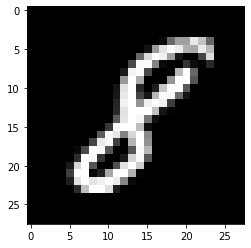

In [ ]:
dataset_check = datasets.MNIST(
    root="data/mnist",
    transform=transforms.ToTensor()
)

x, _ = dataset_check[7777]
plt.imshow(x.numpy()[0], cmap='gray')
print(x.shape)


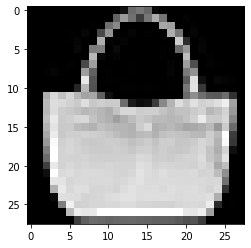

In [ ]:
dataset_check1 = datasets.FashionMNIST(
    root="data/fashion",
    transform=transforms.ToTensor()
)

x1, _ = dataset_check1[100]
plt.imshow(x1.numpy()[0], cmap='gray')

## Neural nets

In [ ]:
class NetTemplate():
    def train_net(self, args, model, device, train_loader, optimizer, epoch, input=False):
        model.train()
        train_loss = 0

        for ix, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            output = model(data)
            # loss = F.cross_entropy(output, target)
            loss = F.nll_loss(output, target)
            train_loss += loss
            
            loss.backward()
            optimizer.step()

            if input and ix % args['res_interval'] == 0:
                print('Epoch for train: {0}, Done: {1}%, Loss: {2}'.format(epoch, 100. * ix / len(train_loader), loss.item()))

        return train_loss


    def test_net(self, model, device, test_loader, test_losses, test_accuracies, input=False):
        model.eval()
        test_loss = 0
        correct = 0

        preds = []
        targets = []
        outputs = []
        datas = []

        with torch.no_grad():
            for ix, (data, target) in enumerate(test_loader):
                if device == "cuda":
                    data, target = data.to(device), target.to(device)
                
                tg_batch = Variable(target.long())
                
                scores = model(data)
                # test_loss += F.cross_entropy(scores, target, reduction='sum').item()
                test_loss += F.nll_loss(scores, target, reduction='sum').item()

                score, predicted = torch.max(scores, 1)
                correct += (tg_batch.data == predicted.data).long().cpu().sum()

                preds.append(predicted)
                targets.append(target)
                outputs.append(scores)
                datas.append(data)

        test_loss /= len(test_loader.dataset)
        accuracy = correct / len(test_loader.dataset)
        test_losses.append(test_loss)
        test_accuracies.append(accuracy)

        if input:
            print('Accuracy for test dataset: {}/{} {}%\n'.format(correct, len(test_loader.dataset), 100. * accuracy))

        return targets, preds, outputs, datas
     


## Net

In [ ]:
class Netn(nn.Module, NetTemplate):
    def __init__(self):
        super(Netn, self).__init__()
        self.lin1 = nn.Linear(15000, 200)
        self.lin2 = nn.Linear(200, 10)
        
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

        self.conv1 = nn.Conv2d(1, 100, 5)
        self.conv2 = nn.Conv2d(100, 150, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.lin1(x))
        x = self.dropout2(x)
        x = self.lin2(x)
        x = F.log_softmax(x, dim=1)
        return x
        

## Net2

In [ ]:
class Net2(nn.Module, NetTemplate):
    def __init__(self, classes_size=10):
        super(Net2, self).__init__()
        self.conv = nn.Conv2d(1, 4, 3, 1)
        self.pool = F.max_pool2d
        self.silu = nn.SiLU()
        self.lin = nn.Linear(676, 10)

    def forward(self, x):
        x = self.conv(x)
        x = self.silu(x)
        x = self.pool(x, 2)
        x = torch.flatten(x, 1)
        x = self.lin(x)
        x = F.log_softmax(x, dim=1)
        return x
        

## Lenet

In [ ]:
class Lenet(nn.Module, NetTemplate):
    def __init__(self):
        super(Lenet,self).__init__()
        self.tanh = nn.Tanh()      
        self.pool = nn.AvgPool2d(2,2)
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.conv3 = nn.Conv2d(16, 120, 3, 1)
        self.lin1 = nn.Linear(1080, 84)
        self.lin2 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.tanh(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.tanh(x)
        x = torch.flatten(x, 1)
        x = self.lin1(x)
        x = self.tanh(x)
        x = self.lin2(x)
        x = F.log_softmax(x, dim=1)
        return x

## Fitting model

In [ ]:
def model_fit_n_pred(model, epochs, train_dataset, test_dataset, input=False):
    model = model.to("cuda")
    optimizer = optim.Adadelta(model.parameters(), lr=args['lr'])

    test_losses = []
    test_accuracies = []
    slr = StepLR(optimizer, step_size=1, gamma=args['gamma'])

    for epoch in range(1, epochs):
        model.train_net(args, model, "cuda", train_dataset, optimizer, epoch, input)
        model.test_net(model, "cuda", test_dataset, test_losses, test_accuracies, input)
        slr.step()

    return test_losses, test_accuracies

model = Netn()
model_fit_n_pred(model, 2, train_fashion, test_fashion, True)

# model_fit_n_pred(model, args['epochs'] + 1, train_fashion, test_fashion, True)


Epoch for train: 1, Done: 0.0%, Loss: 2.3207497596740723
Epoch for train: 1, Done: 9.165902841429881%, Loss: 0.7118916511535645
Epoch for train: 1, Done: 18.331805682859763%, Loss: 0.5492478609085083
Epoch for train: 1, Done: 27.497708524289642%, Loss: 0.48438340425491333
Epoch for train: 1, Done: 36.663611365719525%, Loss: 0.6585519313812256
Epoch for train: 1, Done: 45.8295142071494%, Loss: 0.3146589696407318
Epoch for train: 1, Done: 54.995417048579284%, Loss: 0.35835662484169006
Epoch for train: 1, Done: 64.16131989000917%, Loss: 0.5981689691543579
Epoch for train: 1, Done: 73.32722273143905%, Loss: 0.4401474595069885
Epoch for train: 1, Done: 82.49312557286893%, Loss: 0.4800106883049011
Epoch for train: 1, Done: 91.6590284142988%, Loss: 0.4134983718395233
Accuracy for test dataset: 8732/10000 87.31999969482422%



([0.3635012908935547], [tensor(0.8732)])

## Plots for MNISTS

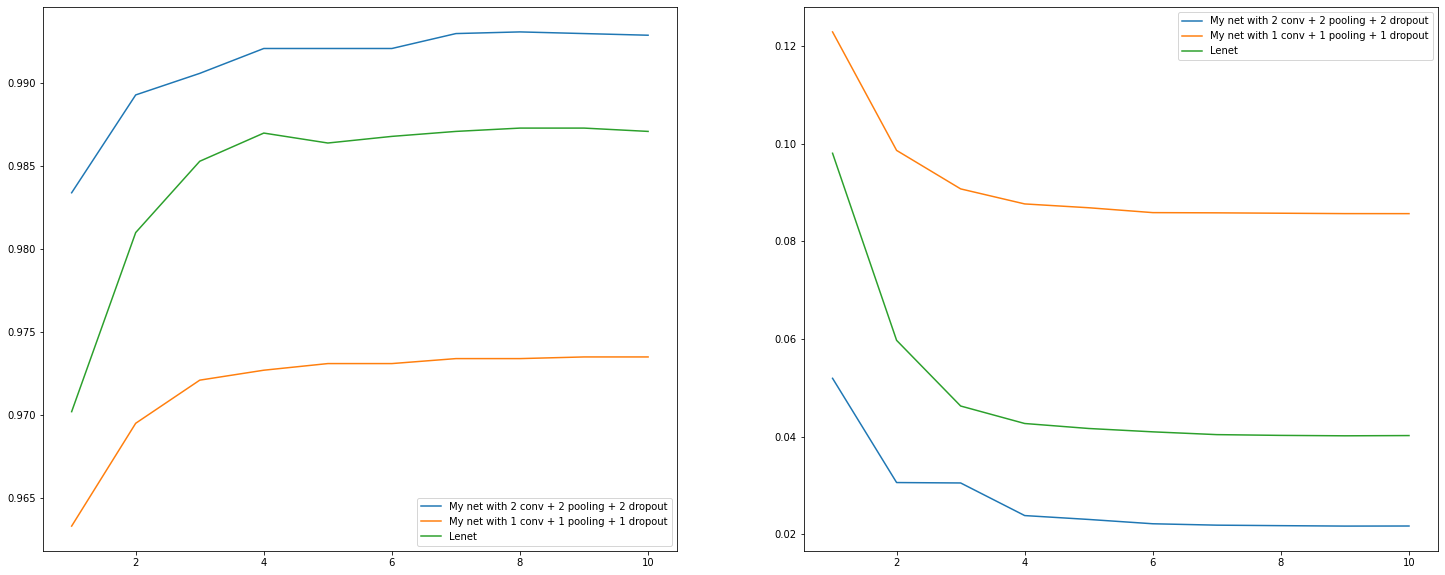

In [ ]:
epochs = [epoch for epoch in range(1, args['epochs'] + 1)]
nets = { 'My net with 2 conv + 2 pooling + 2 dropout' : Netn(), 'My net with 1 conv + 1 pooling + 1 dropout' : Net2(), 'Lenet' : Lenet() }

fig, axs = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(25)

def gen_plots():
    name_b = ""
    accu_b = float('-inf')
    for name, net in nets.items():
        losses, accuracies = model_fit_n_pred(net, args['epochs']+1, train_mnist, test_mnist)
        axs[0].plot(epochs, accuracies, label=name)
        axs[1].plot(epochs, losses, label=name)
        axs[0].legend()
        axs[1].legend()

        if (max(accuracies) > accu_b):
            accu_b = max(accuracies)
            name_b = name

    return name_b

best_net = gen_plots()
plt.show()


## Plots for fashion

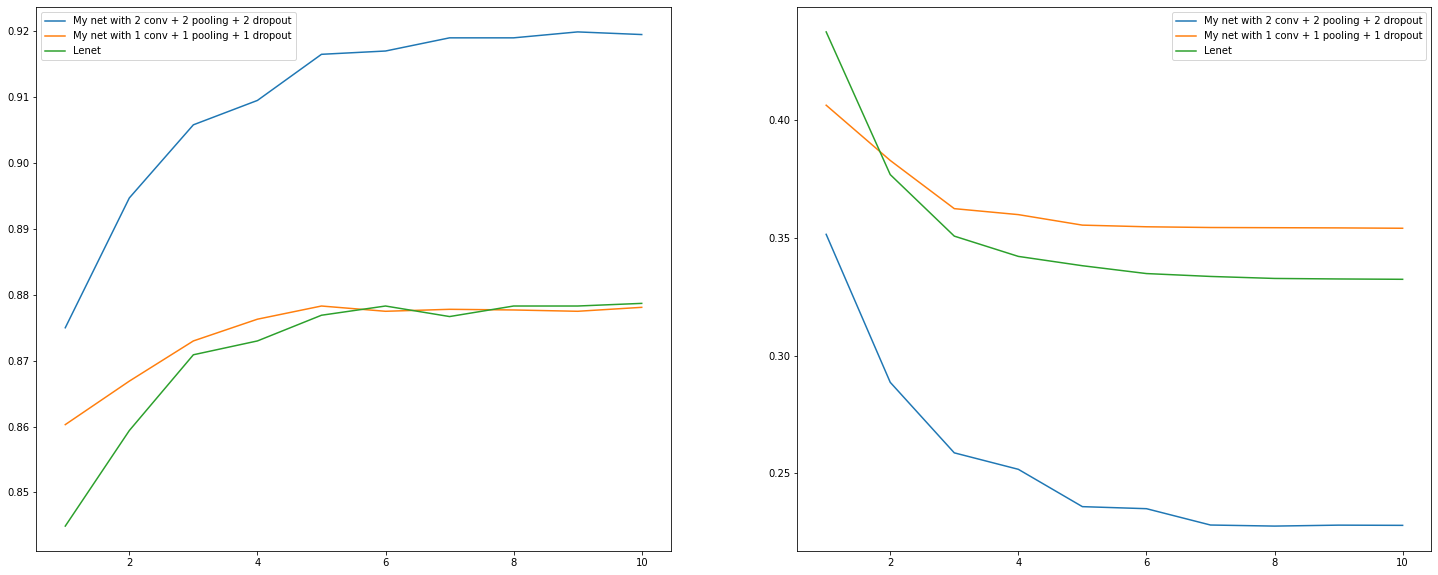

In [ ]:
epochs = [epoch for epoch in range(1, args['epochs'] + 1)]
nets2 = { 'My net with 2 conv + 2 pooling + 2 dropout' : Netn(), 'My net with 1 conv + 1 pooling + 1 dropout' : Net2(), 'Lenet' : Lenet() }

fig, axs = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(25)

def gen_plots():
    name_b = ""
    accu_b = float('-inf')
    for name, net in nets2.items():
        losses, accuracies = model_fit_n_pred(net, args['epochs']+1, train_fashion, test_fashion)
        axs[0].plot(epochs, accuracies, label=name)
        axs[1].plot(epochs, losses, label=name)
        axs[0].legend()
        axs[1].legend()

        if (max(accuracies) > accu_b):
            accu_b = max(accuracies)
            name_b = name

    return name_b

best_net = gen_plots()
plt.show()


## Fashion table for best net

[799, 1, 18, 71, 9, 2, 84, 0, 16, 0]
[0, 967, 0, 23, 7, 0, 1, 0, 2, 0]
[8, 0, 760, 8, 176, 0, 46, 0, 2, 0]
[6, 4, 9, 924, 32, 0, 23, 0, 2, 0]
[1, 1, 38, 48, 887, 0, 25, 0, 0, 0]
[0, 0, 0, 0, 0, 957, 0, 38, 0, 5]
[130, 1, 79, 62, 155, 0, 551, 0, 22, 0]
[0, 0, 0, 0, 0, 11, 0, 963, 0, 26]
[0, 2, 2, 5, 6, 3, 2, 4, 976, 0]
[0, 0, 1, 0, 0, 8, 0, 43, 0, 948]


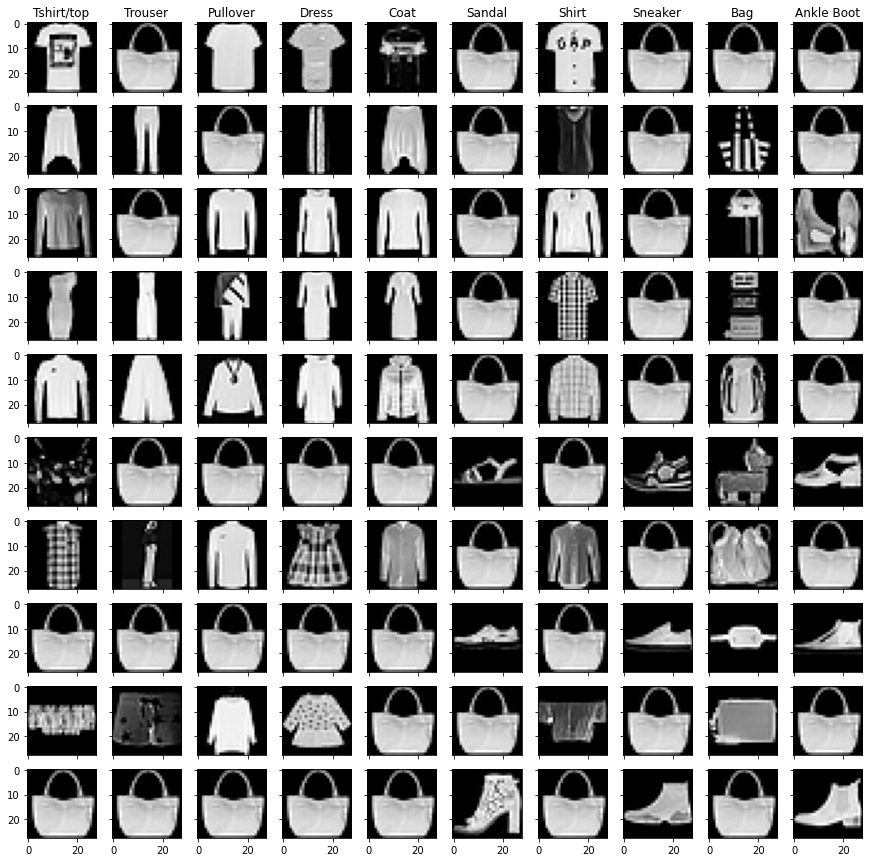

In [ ]:
tgs, prs, ots, dts = nets2[best_net].test_net(model, "cuda", test_fashion, [], [])
confusion_matrix = [[0 for _ in range(10)] for __ in range(10) ]
images = [[None for _ in range(10)] for __ in range(10)]
images_score = [[float('-inf') for _ in range(10)] for __ in range(10)]

def gen_matrices():
    for ix in range(len(tgs)):
        for tg, pr, ot, dt in zip(tgs[ix].view_as(prs[ix]), prs[ix], ots[ix], dts[ix]):
            tg = tg.item()
            pr = pr.item()
            confusion_matrix[tg][pr] += 1

            if ot[pr].item() > images_score[pr][tg]:
                images[pr][tg] = dt
                images_score[pr][tg] = ot[pr].item()

def show_table(imgs):
    fig, ax = plt.subplots(10, 10, True, True, figsize=(15,15))
    fig.frameon = False
    for ix, imgs_ in enumerate(imgs):
        buff = []
        for jx in range(10):
            if ix == 0:
                ax[0][jx].set_title(args['classes'][jx])

            ax[ix][jx].imshow(imgs_[jx].cpu().numpy()[0] if imgs_[jx] != None else x1.numpy()[0] , cmap='gray')


def print_m(mat):
    for i in mat:
        print(i)

gen_matrices()
show_table(images)
print_m(confusion_matrix)